In [39]:
from typing import List, Tuple, Self, Union

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt

class BoundingBox:
    """
    Represents an axis-aligned bounding box (AABB).

    Attributes:
        min (np.ndarray): Minimum coordinates (x, y) of the bounding box.
        max (np.ndarray): Maximum coordinates (x, y) of the bounding box.
    """

    def __init__(self, min_coords: np.ndarray, max_coords: np.ndarray):
        """
        Initialize the bounding box with min and max coordinates.

        Args:
            min_coords (np.ndarray): Minimum coordinates of the bounding box as a 2D vector.
            max_coords (np.ndarray): Maximum coordinates of the bounding box as a 2D vector.
        """
        self.min = min_coords
        self.max = max_coords

    def overlaps(self, other: Self) -> bool:
        """
        Check if this bounding box overlaps with another bounding box.

        Args:
            other (BoundingBox): The other bounding box to check against.

        Returns:
            bool: True if the bounding boxes overlap, False otherwise.
        """
        return (self.min[0] < other.max[0] and
                self.max[0] > other.min[0] and
                self.min[1] < other.max[1] and
                self.max[1] > other.min[1])
    
    
    def expand(self, margin: float) -> None:
        """
        Expands the bounding box by a specified margin, increasing its size uniformly in all directions.

        Args:
            margin (float): The margin by which to expand each side of the bounding box.
                        A positive value increases the size of the bounding box, while a negative value shrinks it.
                        The margin is applied to both the minimum and maximum bounds in all dimensions.

        """
        if margin >= 0:
            self.min -= margin
            self.max += margin
        else:
            self.min += margin
            self.max -= margin

    def contains_point(self, point: np.ndarray) -> bool:
        """
        Checks if the bounding box fully contains a given point.

        Args:
            point (np.ndarray): The point to check, represented as a 2D vector with (x, y) coordinates.
                                The point is expected to be a NumPy array of shape (2,).

        Returns:
            bool: True if the point lies within the bounds of the bounding box, including on its edges.
                False if the point lies outside the bounding box.
        """
        return (self.min[0] <= point[0] <= self.max[0] and
                self.min[1] <= point[1] <= self.max[1])


    def update(self, new_min: np.ndarray, new_max: np.ndarray) -> None:
        """
        Updates the bounding box with new minimum and maximum coordinates.

        Args:
            new_min (np.ndarray): New minimum coordinates of the bounding box, given as a NumPy array of shape (2,).
                                Represents the lower corner of the bounding box (x_min, y_min).
            new_max (np.ndarray): New maximum coordinates of the bounding box, given as a NumPy array of shape (2,).
                                Represents the upper corner of the bounding box (x_max, y_max).

        Returns:
            None: This method modifies the bounding box in place.
                It does not return a new instance but rather updates the current bounding box's min and max attributes.
        """
        self.min, self.max = new_min, new_max

    def plot(self, axis: matplotlib.axes._axes.Axes) -> None:
        """
        Plot the bounding box on the given axis.

        Args:
            axis (matplotlib.axes._axes.Axes): The axis on which to plot the bounding box.
        """
        x0, y0 = self.min
        x1, y1 = self.max
        axis.hlines(y0, x0, x1)
        axis.hlines(y1, x0, x1)
        axis.vlines(x0, y0, y1)
        axis.vlines(x1, y0, y1)


class Particle:
    """
    Represents a physical particle in the simulation.

    Attributes:
        position (np.ndarray): The position of the particle as a 2D vector.
        velocity (np.ndarray): The velocity of the particle as a 2D vector.
        bounding_box (BoundingBox): Bounding box for collision detection.
    """

    def __init__(self, 
                 position: np.ndarray, 
                 velocity: np.ndarray, 
                 radius: float,
                 density: float,
                 restitution: float,
                 bounding_box: BoundingBox):
        """
        Initialize a particle with position, velocity, and bounding box.

        Args:
            position (np.ndarray): Initial position of the particle as a 2D vector.
            velocity (np.ndarray): Initial velocity of the particle as a 2D vector.
            radius (float): The radius of the particle.
            density (float): The density of the particle. 
            restitution (float): The coefficient of restitution used in the collisions. 
            bounding_box (BoundingBox): The bounding box of the particle.
        """
        self.position = position
        self.velocity = velocity
        self.radius = radius
        self.density = density
        self.restitution = restitution
        self.mass = self._calculate_mass()
        self.bounding_box = bounding_box

    def _calculate_mass(self) -> float:
        """
        Calculate the mass of the particle based on its density and radius.
        In 2D, mass is proportional to area (π * r²).
        
        :return: The calculated mass of the particle.
        """
        return np.pi * (self.radius ** 2) * self.density  # In 2D, mass is proportional to area

    def update_position(self, dt: float):
        """
        Update the particle's position based on velocity.

        Args:
            dt (float): Time step for the update.
        """
        self.position += self.velocity * dt

    def apply_force(self, force: np.ndarray, dt: float) -> None:
        """
        Applies a force to the particle, updating its velocity according to Newton's second law of motion.

        Args:
            force (np.ndarray): The force to be applied to the particle as a 2D vector with (x, y) components.
                                This should be a NumPy array of shape (2,).
            dt (float): Time step over which the force is applied. Represents the time interval in seconds.
                        The time step should be positive and non-zero.

        Returns:
            None: This method updates the velocity of the particle in place, taking into account the force applied.
                The position remains unchanged until the next position update.
        """
        self.velocity += force * dt / self.mass

    def update_bounding_box(self) -> None:
        """
        Updates the bounding box of the particle based on its current position.
        The bounding box is recalculated to ensure it fully encloses the particle at its current position.

        Args:
            None

        Returns:
            None: This method modifies the bounding_box attribute of the particle.
                It recalculates the bounds based on the particle's position and updates the bounding box in place.
        """
        self.bounding_box.min, self.bounding_box.max = self.position-self.radius, self.position+self.radius
    

    def collide_with(self, other: Self) -> None:
        """
        Handles collision resolution between this particle and another particle using impulse-based collision response.

        Args:
            other (Particle): The other particle to resolve the collision with.
                            The method assumes that a collision has already been detected between the two particles.

        Returns:
            None: This method updates the velocities and potentially the positions of both particles
                to account for the collision. It does not return a new object.
                The calculation is based on the relative velocity and restitution coefficients of the particles.
        """
        # Calculate the normal vector between the two particles
        normal = other.position - self.position
        distance = np.linalg.norm(normal)
        normal /= distance

        # Calculate the relative velocity
        relative_velocity = other.velocity - self.velocity

        # Calculate the velocity along the normal direction (project onto normal component of velocity)
        velocity_along_normal = np.dot(relative_velocity, normal)

        # If the particles are moving apart, do nothing
        if velocity_along_normal > 0:
            return

        # Calculate the effective restitution 
        effective_restitution = 0.5 * (self.restitution + other.restitution)

        # Calculate the impulse scalar
        impulse_scalar = -(1 + effective_restitution) * velocity_along_normal
        impulse_scalar /= (1 / self.mass + 1 / other.mass)

        # Calculate the impulse vector
        impulse = impulse_scalar * normal

        # Update the velocities of both particles
        self.velocity -= impulse / self.mass
        other.velocity += impulse / other.mass



class SweepAndPrune:
    """
    Performs sweep-and-prune broad-phase collision detection.

    Methods:
        detect_collisions(objects: List[Particle]) -> List[Tuple[Particle, Particle]]: 
            Detect potential collisions using SaP.
    """

    def detect_collisions(self, objects: List[Particle]) -> List[Tuple[Particle, Particle]]:
        """
        Perform sweep-and-prune to detect possible collisions between particles.

        Args:
            objects (List[Particle]): List of particles in a KD-Tree leaf node.

        Returns:
            List[Tuple[Particle, Particle]]: List of potentially colliding particle pairs.
        """
        pass

    def sort_objects(self, objects: List[Particle], axis: int) -> List[Particle]:
        """
        Sorts a list of particles along a specified axis, either x or y, for use in the sweep-and-prune algorithm.

        Args:
            objects (List[Particle]): A list of Particle instances to be sorted.
                                    Each Particle must have a valid position attribute.
            axis (int): The index of the axis to sort by (0 for x-axis, 1 for y-axis).
                        Sorting is done based on the particle's position along the specified axis.

        Returns:
            List[Particle]: A new list of Particle instances sorted by their position along the specified axis.
                            The original list is not modified.
        """
        pass

    def find_overlaps(self, sorted_objects: List[Particle]) -> List[Tuple[Particle, Particle]]:
        """
        Identifies overlapping intervals among sorted objects using their bounding boxes.
        This method assumes that the objects have already been sorted along one axis.

        Args:
            sorted_objects (List[Particle]): A list of Particle instances sorted by their position along an axis.
                                            Each particle must have a bounding box defined.

        Returns:
            List[Tuple[Particle, Particle]]: A list of tuples, where each tuple represents a pair of particles whose
                                            bounding boxes overlap along the sorted axis.
                                            This list is used as a candidate set for further collision checking.
        """
        pass

    def process_collisions(self, collision_pairs: List[Tuple[Particle, Particle]]) -> None:
        """
        Processes and resolves detected overlaps from the broad-phase collision detection.

        Args:
            collision_pairs (List[Tuple[Particle, Particle]]): A list of particle pairs that are potentially colliding.
                                                            Each pair consists of two Particle instances that were
                                                            found to overlap based on the broad-phase method.

        Returns:
            None: This method performs collision resolution on each pair in place, adjusting particle velocities and positions.
                It does not return a new list but modifies the particles directly.
        """
        pass




class KDNode:
    """
    Represents a node in the KD-Tree.

    Attributes:
        objects (List[Particle]): List of particles in the node.
        left (KDNode): Left child node.
        right (KDNode): Right child node.
        bounding_box (BoundingBox): Bounding box for the region covered by this node.
    """

    def __init__(self, objects: List[Particle], left: Union[Self,None] = None, right: Union[Self,None] = None):
        """
        Initialize a KD-Tree node.

        Args:
            objects (List[Particle]): List of particles in this node.
            left (KDNode): Left child node.
            right (KDNode): Right child node.
        """
        self.objects = objects
        self.left = left
        self.right = right
        self.bounding_box = self._calculate_bounding_box()

    def _calculate_bounding_box(self) -> BoundingBox:
        """
        Calculate the bounding box for the particles in this node.

        Returns:
            BoundingBox: Bounding box covering all particles in this node.
        """
        pass

    def is_leaf(self) -> bool:
        """
        Checks if the current KD-Tree node is a leaf node, meaning it has no child nodes.

        Args:
            None

        Returns:
            bool: True if the node is a leaf node (i.e., both left and right child nodes are None),
                False if it has either or both child nodes.
        """
        pass

    def split(self) -> Tuple[Self, Self]:
        """
        Splits the current KD-Tree node into left and right child nodes based on a splitting plane.
        The split is determined based on the variance of particle positions along the chosen axis.

        Args:
            None

        Returns:
            Tuple[KDNode, KDNode]: A tuple containing the left and right child nodes created by the split.
                                Each child node contains a subset of particles and covers a specific region of space.
        """
        pass

    def insert(self, particle: Particle) -> None:
        """
        Inserts a particle into the appropriate sub-tree based on its position.

        Args:
            particle (Particle): The particle to insert. The method determines the correct leaf node for this particle
                                based on its position relative to the splitting planes.

        Returns:
            None: The particle is inserted into the correct position in the tree structure.
                The method modifies the node or its children as needed.
        """
        pass

    def query(self, region: BoundingBox) -> List[Particle]:
        """
        Gathers particles within a specified region by recursively querying the KD-Tree.

        Args:
            region (BoundingBox): The bounding box defining the region to query.
                                Particles whose bounding boxes overlap with this region will be included in the results.

        Returns:
            List[Particle]: A list of particles that are found within the specified region.
                            This list may include particles from the current node or its child nodes.
        """
        pass



class KDTree:
    """
    KD-Tree for spatial subdivision of simulation space for broad-phase collision detection.

    Attributes:
        root (KDNode): The root node of the KDTree.
    """

    def __init__(self, objects: List[Particle], max_leaf_size: int = 10):
        """
        Initialize the KD-Tree with the particles' positions.

        Args:
            objects (List[Particle]): List of particles (with positions) to build the tree from.
            max_leaf_size (int): Maximum number of particles per leaf node.
        """
        self.root = self._build_tree(objects, max_leaf_size)

    def _build_tree(self, objects: List[Particle], max_leaf_size: int) -> KDNode:
        """
        Recursively build the KD-Tree by subdividing the space.

        Args:
            objects (List[Particle]): List of particles to divide into KDTree nodes.
            max_leaf_size (int): Maximum number of particles in a leaf node.

        Returns:
            KDNode: Root node of the built KDTree.
        """
        pass

    def update_tree(self, objects: List[Particle]):
        """
        Update the KD-Tree structure based on updated particle positions.

        Args:
            objects (List[Particle]): Updated particle list with new positions.
        """
        pass

    def query_region(self, region: BoundingBox) -> List[Particle]:
        """
        Query the KD-Tree for particles within a given region.

        Args:
            region (BoundingBox): The region to query.

        Returns:
            List[Particle]: List of particles within the region.
        """
        pass

    def balance(self) -> None:
        """
        Balances the KD-tree to ensure efficient querying and insertion.
        Balancing involves rearranging nodes and adjusting splitting planes to minimize tree depth.

        Args:
            None

        Returns:
            None: The KD-Tree structure is modified in place to maintain balance.
                This helps improve performance for spatial queries and collision detection.
        """
        pass

    def rebalance_if_needed(self) -> None:
        """
        Checks if the KD-tree has become unbalanced due to particle movement and rebalances it if necessary.
        Rebalancing is triggered if certain thresholds (e.g., maximum depth or particle count per leaf) are exceeded.

        Args:
            None

        Returns:
            None: The KD-Tree is rebalanced if the conditions are met, improving query performance.
                If no rebalancing is needed, the method performs no changes.
        """
        pass

    def query_range(self, region: BoundingBox) -> List[Particle]:
        """
        Finds all particles whose bounding boxes intersect with a specified bounding box region.

        Args:
            region (BoundingBox): The bounding box defining the spatial area to query.
                                Particles overlapping this region are considered for collision detection.

        Returns:
            List[Particle]: A list of particles within the specified region.
                            This list is used for further narrow-phase collision checks.
        """
        pass



True

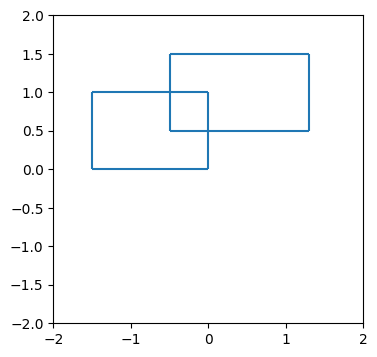

In [46]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
AABB1 = BoundingBox(np.array([-1.5,0]),
                    np.array([0,1]))
AABB2 = BoundingBox(np.array([-0.5,0.5]),
                    np.array([1.3,1.5]))

AABB1.plot(ax)
AABB2.plot(ax)
AABB1.overlaps(AABB2)